In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

Change figsize to control relative font size and aspect ratio. Increase DPI for higher resolution.

In [464]:
plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['figure.dpi'] = 200

## Reading data

In [403]:
row_start = 14
trial_ids = [13, 17, 18, 19, 20]
n_trials = len(trial_ids)

color1a = "indigo"
color2a = "tomato"

color1b = "blue"
color2b = "red"

label1 = "in"
label2 = "out"

In [404]:
trials = []
for trial_id in trial_ids:
    trial = {
        "id": trial_id
    }
    
    filename = f"gaussian/T{trial_id:04}ALL.CSV"
    
    metadata = dict()
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for (i, row) in enumerate(reader):
            if i > row_start: break
            if len(row) >= 2: metadata[row[0]] = row[1]
    trial["metadata"] = metadata
                
    trial["data"] = pd.read_csv(filename, delimiter=",", header=row_start)
    trials.append(trial)

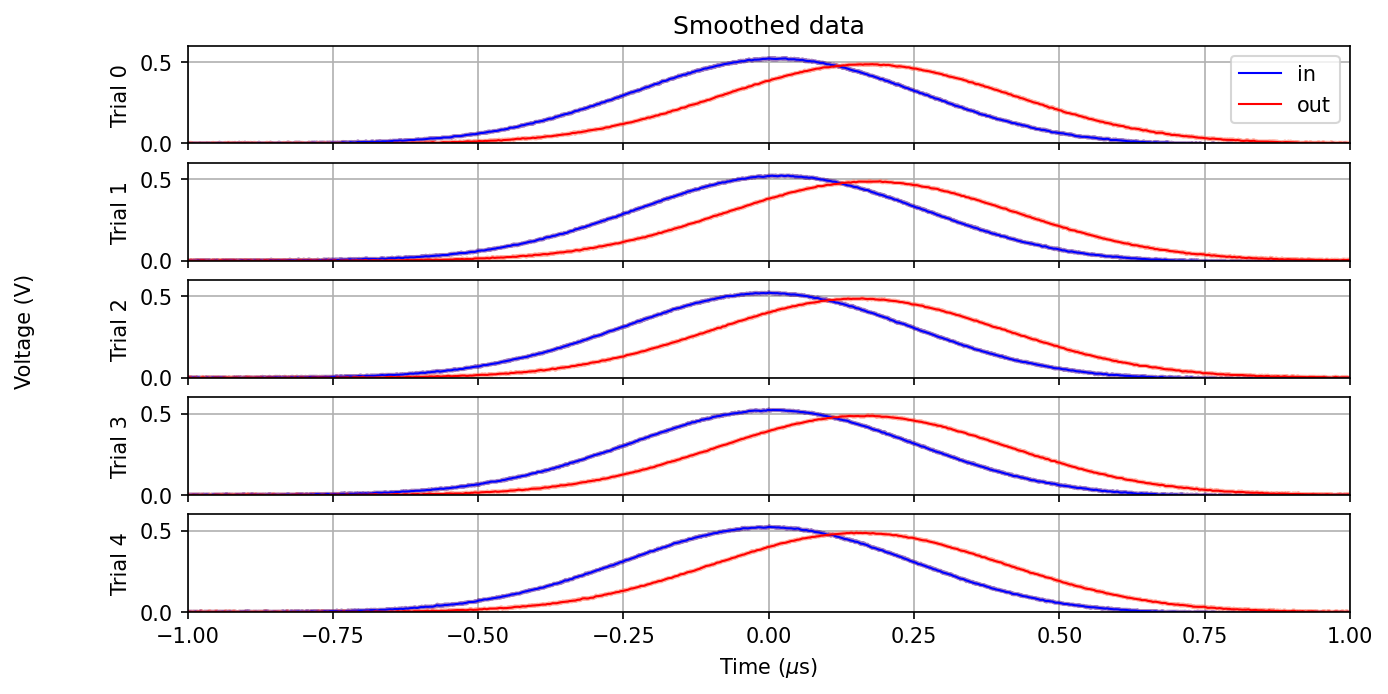

In [405]:
fig, axs = plt.subplots(n_trials, 1, sharex=True, figsize=(10, n_trials))

for n, trial in enumerate(trials):
    data = trial["data"]
    
    plt.sca(axs[n])
    t_raw = data["TIME"].to_numpy()*1e6
    ch1_raw = data["CH1"].to_numpy()
    try:
        ch2_raw = data["CH2"].to_numpy()
    except KeyError:
        ch2_raw = data["CH3"].to_numpy()

    near = np.abs(t_raw - t_raw[np.argmax(ch1_raw)])
    select = near < 3
    antiselect = np.logical_and(near > 3, near < 1000)
    
    t = t_raw[select]
    t -= np.mean(t)
    dt = np.average(np.diff(t))
    
    ch1_noisy = ch1_raw[select] - np.mean(ch1_raw[antiselect])
    ch2_noisy = ch2_raw[select] - np.mean(ch2_raw[antiselect])
    
    ch1 = sp.signal.savgol_filter(ch1_noisy, 10, 3)
    ch2 = sp.signal.savgol_filter(ch2_noisy, 10, 3)

    trial.update({
        "t": t,
        "dt": dt,
        "ch1": ch1,
        "ch2": ch2,
    })
        
    plt.plot(t, ch1_noisy, lw=2, alpha=0.5, c=color1a)
    plt.plot(t, ch2_noisy, lw=2, alpha=0.5, c=color2a)
    
    plt.plot(t, ch1, label=label1, lw=1, c=color1b)
    plt.plot(t, ch2, label=label2, lw=1, c=color2b)

    plt.ylabel(f"Trial {n}")
    plt.ylim(0, 0.6)
    plt.grid()
    plt.margins(0)

plt.sca(axs[0])
plt.title("Smoothed data")
plt.legend()

plt.sca(axs[-1])
fig.text(0.01, 0.5, "Voltage (V)", va='center', rotation='vertical')
plt.xlabel("Time ($\mu$s)")
plt.xlim(-1,1)
plt.show()

## Fitting data

In [406]:
## Gaussian curve
curve = lambda t, A, g: A / np.exp((t/g)**2)

double = lambda t, A, g, h, x, y: curve(t-x, A, g) + curve(t-y, A, h)
delayed = lambda t, A, g, x: curve(t-x, A, g)

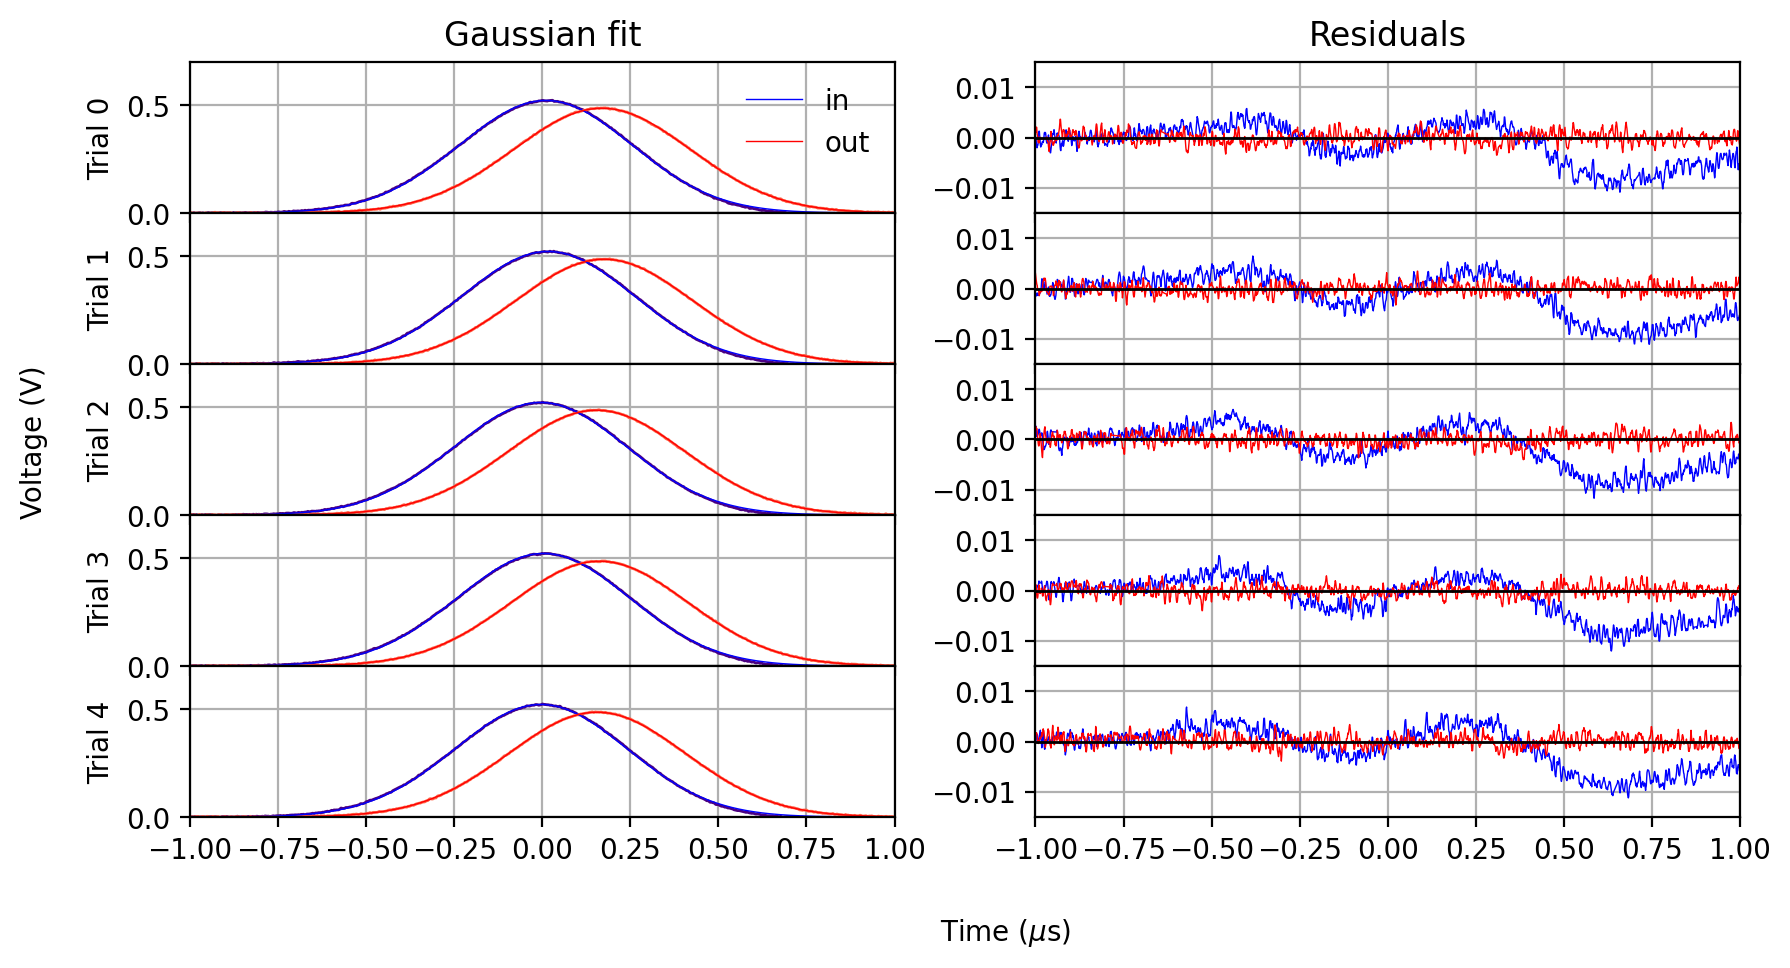

In [477]:
fig, axs = plt.subplots(n_trials, 2, sharex=True, figsize=(10, n_trials))

for n, trial in enumerate(trials):
    t = trial["t"]
    ch1 = trial["ch1"]
    ch2 = trial["ch2"]
    
    [[a1, g1, x1], cov1] = sp.optimize.curve_fit(delayed, t, ch1, p0=[1, 0.34, -0.1])
    [[a2, g2, x2], cov2] = sp.optimize.curve_fit(delayed, t, ch2, p0=[1, 0.34, -0.0])

    [da1, dg1, dx1] = np.sqrt(np.diagonal(cov1))
    [da2, dg2, dx2] = np.sqrt(np.diagonal(cov1))

    trial.update({
        "a1": a1, "da1": da1,
        "g1": g1, "dg1": dg1,
        "x1": x1, "dx1": dx1,
        
        "a2": a2, "da2": da2,
        "g2": g2, "dg2": dg2,
        "x2": x2, "dx2": dx2,
    })
    
    # Curves fit to channels
    fit1 = delayed(t, A1, g1, x1)
    fit2 = delayed(t, A2, g2, x2)
    
    plt.sca(axs[n][0])
    plt.plot(t, ch1, lw=1, c="indigo", alpha=1)
    plt.plot(t, ch2, lw=1, c="tomato", alpha=1)
    
    plt.plot(t, fit1, label="in", lw=0.5, c="blue")
    plt.plot(t, fit2, label="out", lw=0.5, c="red")

    plt.ylabel(f"Trial {n}")
    plt.xlim(-1,1)
    plt.ylim(0,0.7)
    
    plt.grid()
    
    plt.sca(axs[n][1])
    res1 = ch1 - fit1
    res2 = ch2 - fit2
    plt.ylim(-0.015, 0.015)
    plt.plot(t, res1, lw=0.5, c="blue")
    plt.plot(t, res2, lw=0.5, c="red")
    plt.axhline(0, c="black", lw=1)
    plt.grid()


plt.sca(axs[0,0])
plt.title("Gaussian fit")
plt.legend(frameon=False)

plt.sca(axs[0,1])
plt.title("Residuals")

plt.sca(axs[-1,0])
fig.text(0.04, 0.5, "Voltage (V)", va='center', rotation='vertical')
fig.text(0.5, 0.01, "Time ($\mu$s)", va='center', rotation='horizontal')
plt.subplots_adjust(hspace=0)
plt.show()

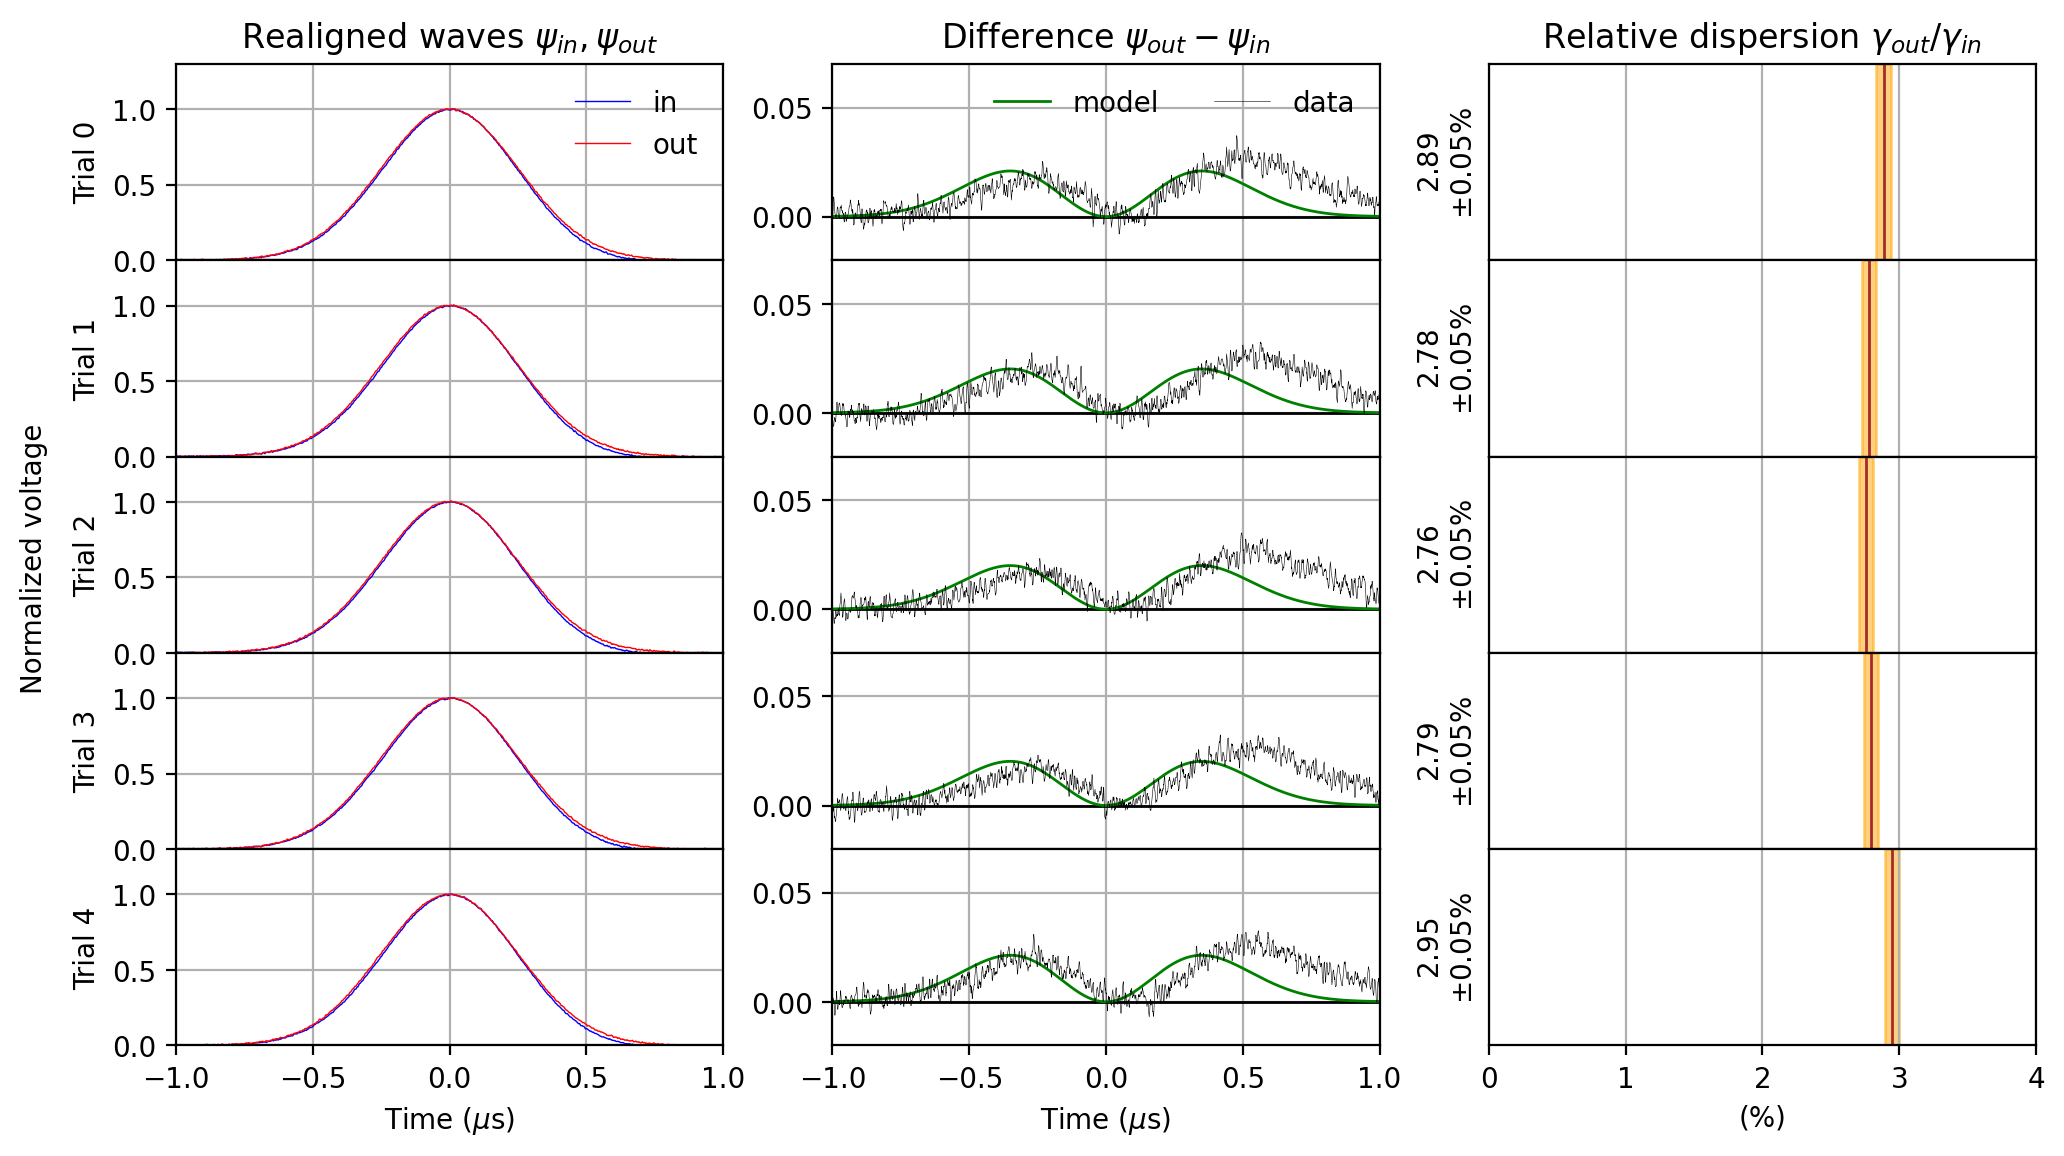

In [510]:
fig, axs = plt.subplots(n_trials, 3, figsize=(12, 1.3*n_trials), )

for n, trial in enumerate(trials):

    t = trial["t"]
    dt = trial["dt"]
    
    ch1 = trial["ch1"]
    ch2 = trial["ch2"]

    x1 = trial["x1"]
    x2 = trial["x2"]

    a1 = trial["a1"]
    a2 = trial["a2"]

    g1 = trial["g1"]
    g2 = trial["g2"]
    
    shift0 = 500
    shift1 = -int(x1/dt)
    shift2 = -int(x2/dt)
    ret = t[shift0+shift1+shift2:-shift0-shift1-shift2]
    re1 = np.array([ ch1[ np.abs(t-x1-tt) < 0.8*dt ][0] / a1 for tt in ret ])
    re2 = np.array([ ch2[ np.abs(t-x2-tt) < 0.8*dt ][0] / a2 for tt in ret ])

    trial.update({
        "ret": ret,
        "re1": re1,
        "re2": re2,
    })

    plt.sca(axs[n,0])
    plt.plot(ret, re1, c=color1b,  label=label1, lw=0.5)
    plt.plot(ret, re2, c=color2b,  label=label2, lw=0.5)
    # plt.plot(t, curve(t, 1, g1), label=label1, lw=1, c=color1b)
    # plt.plot(t, curve(t, 1, g2), label=label2, lw=1, c=color2b)
    if n+1 < n_trials: 
        plt.tick_params(axis='x', which='both', bottom=False, labelleft=False, labelbottom=False)
    else:
        plt.xlabel("Time ($\mu$s)")

    plt.ylabel(f"Trial {n}")
    plt.ylim(0,1.3)
    plt.xlim(-1,1)
    plt.grid()
    
    plt.sca(axs[n,1])
    plt.xlim(-1,1)
    plt.axhline(0, c="black", lw=1)
    if n+1 < n_trials: 
        plt.tick_params(axis='x', which='both', bottom=False, labelleft=False, labelbottom=False)
    else:
        plt.xlabel("Time ($\mu$s)")

    plt.plot(ret, curve(ret, 1, g2) - curve(ret, 1, g1), lw=1, c="green", label="model")
    plt.plot(ret, re2 - re1, lw=0.2, c="black", label="data")
    plt.grid()
    plt.ylim(-0.02,0.07)

    plt.sca(axs[n,2])
    plt.yticks([],[])
    if n+1 < n_trials: 
        plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    else:
        plt.xlabel("(%)")

    g = g2/g1 - 1
    dg = np.sqrt( dg2**2 + (dg1*g2/g1)**2 ) / g1
    plt.axvline(g*100, lw=1, color="brown")
    plt.axvspan((g - dg)*100, (g + dg)*100, alpha=0.5, color="orange")
    plt.grid()
    plt.ylabel(f"${g*100:.2f}%$\n$\pm {dg*100:.2f}$%")
    plt.xlim(0, 4)

plt.sca(axs[0,0])
plt.title(r"Realigned waves $\psi_{in}, \psi_{out}$")
plt.legend(frameon=False)

plt.sca(axs[0,1])
plt.title("Difference $\psi_{out} - \psi_{in}$")
plt.legend(frameon=False, ncol=2, scatterpoints=10)

plt.sca(axs[0,2])
plt.title("Relative dispersion $\gamma_{out}/\gamma_{in}$")

fig.text(0.06, 0.5, "Normalized voltage", va='center', rotation='vertical')
plt.subplots_adjust(hspace=0)
plt.show()

## Present single trial

In [512]:
trial = trials[0]

t = trial["t"]
ch1 = trial["ch1"]
ch2 = trial["ch2"]

ret = trial["ret"]
re1 = trial["re1"]
re2 = trial["re2"]

g1 = trial["g1"]
g2 = trial["g2"]

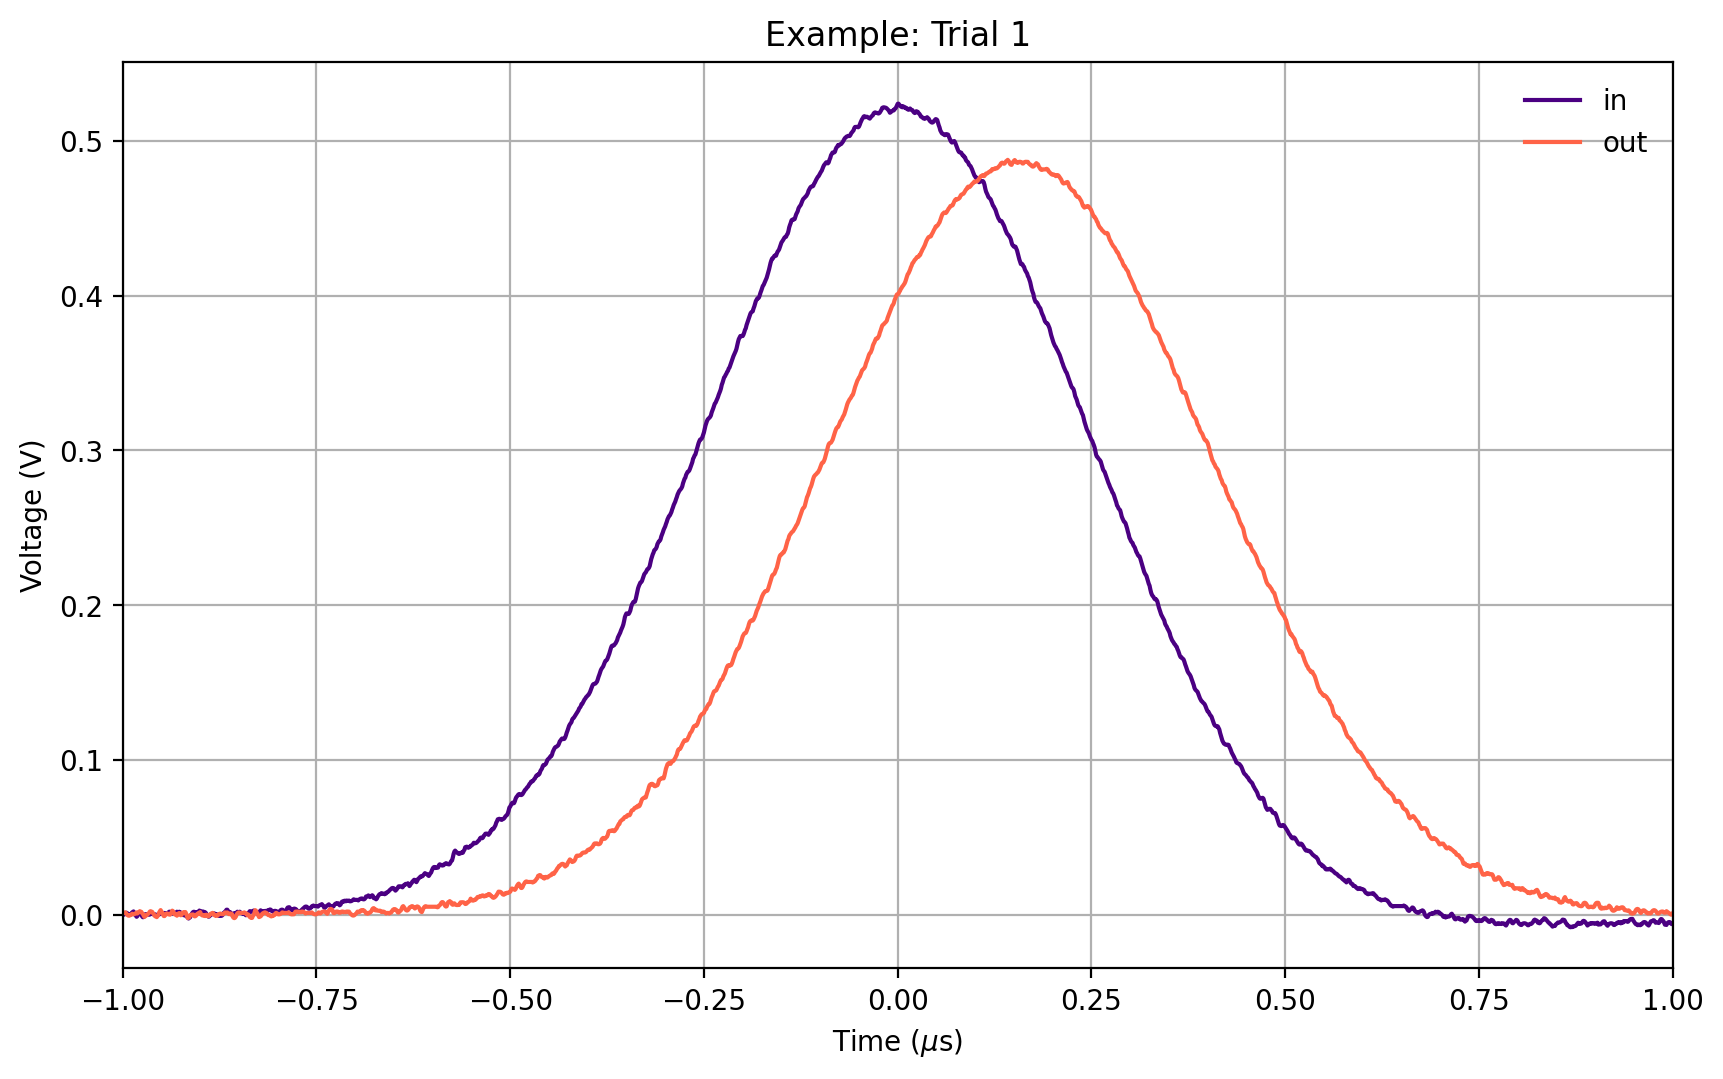

In [533]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
plt.sca(ax)
plt.title("Example: Trial 1")
plt.plot(t, ch1, color=color1a, label="in")
plt.plot(t, ch2, color=color2a, label="out")
plt.xlim(-1, 1)
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Voltage (V)")
plt.legend(frameon=False)
plt.grid()


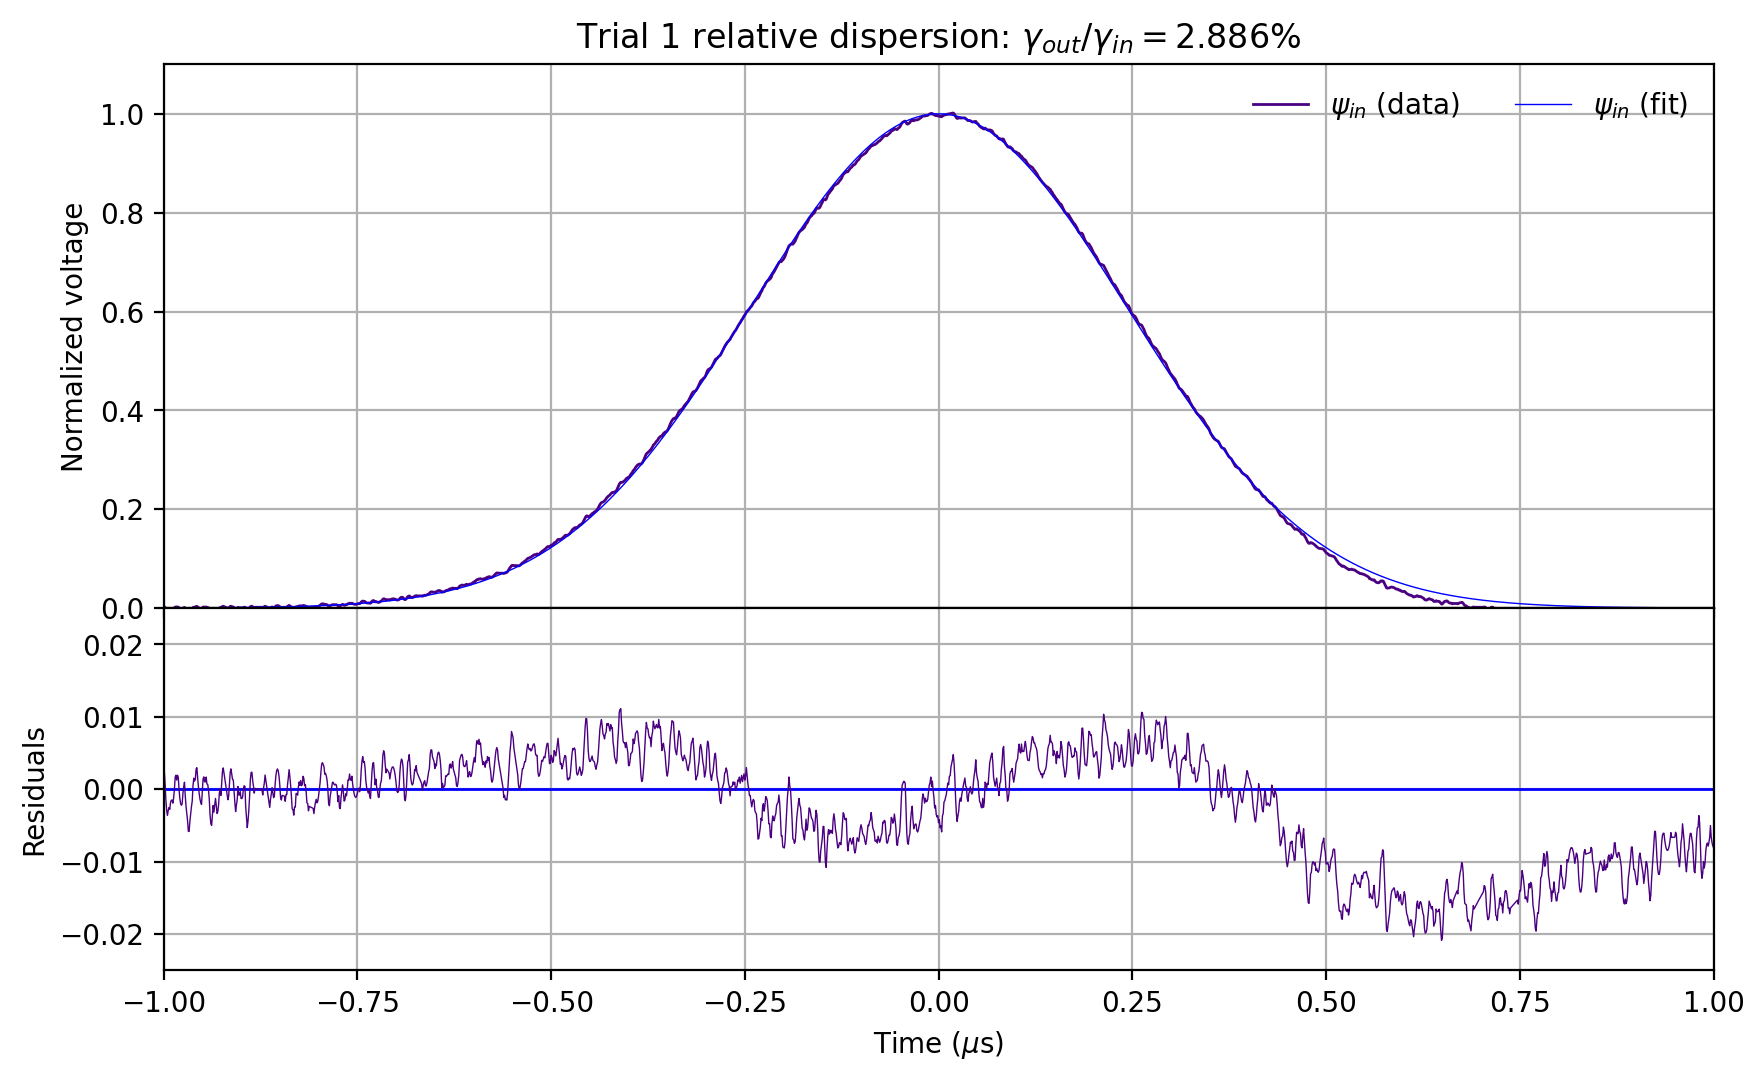

In [524]:
fig, [ax1, ax2] = plt.subplots(2,1,sharex=True,figsize=(10,6),gridspec_kw={'height_ratios': [3,2]})

plt.sca(ax1)
plt.title("Trial 1 relative dispersion: $\gamma_{out}/\gamma_{in} = $" + f"{100*(g2/g1-1):.3f}%")
plt.plot(ret, re1, c="indigo", label="$\psi_{in}$ (data)", lw=1)
# plt.plot(ret, re2, c="tomato", label="$\psi_{out}$ (data)", lw=1)
plt.plot(t, curve(t, 1, g1), lw=0.5, c="blue", label="$\psi_{in}$ (fit)")
# plt.plot(t, curve(t, 1, g2), lw=0.5, c="red", label="$\psi_{out}$ (fit)")
plt.ylim(0,1.1)
plt.xlim(-1,1)
plt.ylabel("Normalized voltage")
plt.grid()
plt.legend(frameon=False,ncol=2)

plt.sca(ax2)
plt.axhline(0, c="blue", lw=1)
plt.ylabel("Residuals")
plt.plot(ret, re1 - curve(ret, 1, g1), lw=0.5, c="indigo")
# plt.plot(ret, re2 - curve(ret, 1, g2), lw=0.5, c="tomato")
plt.grid()
plt.ylim(-0.025,0.025)

plt.xlabel("Time ($\mu$s)")

plt.subplots_adjust(hspace=0)
plt.show()

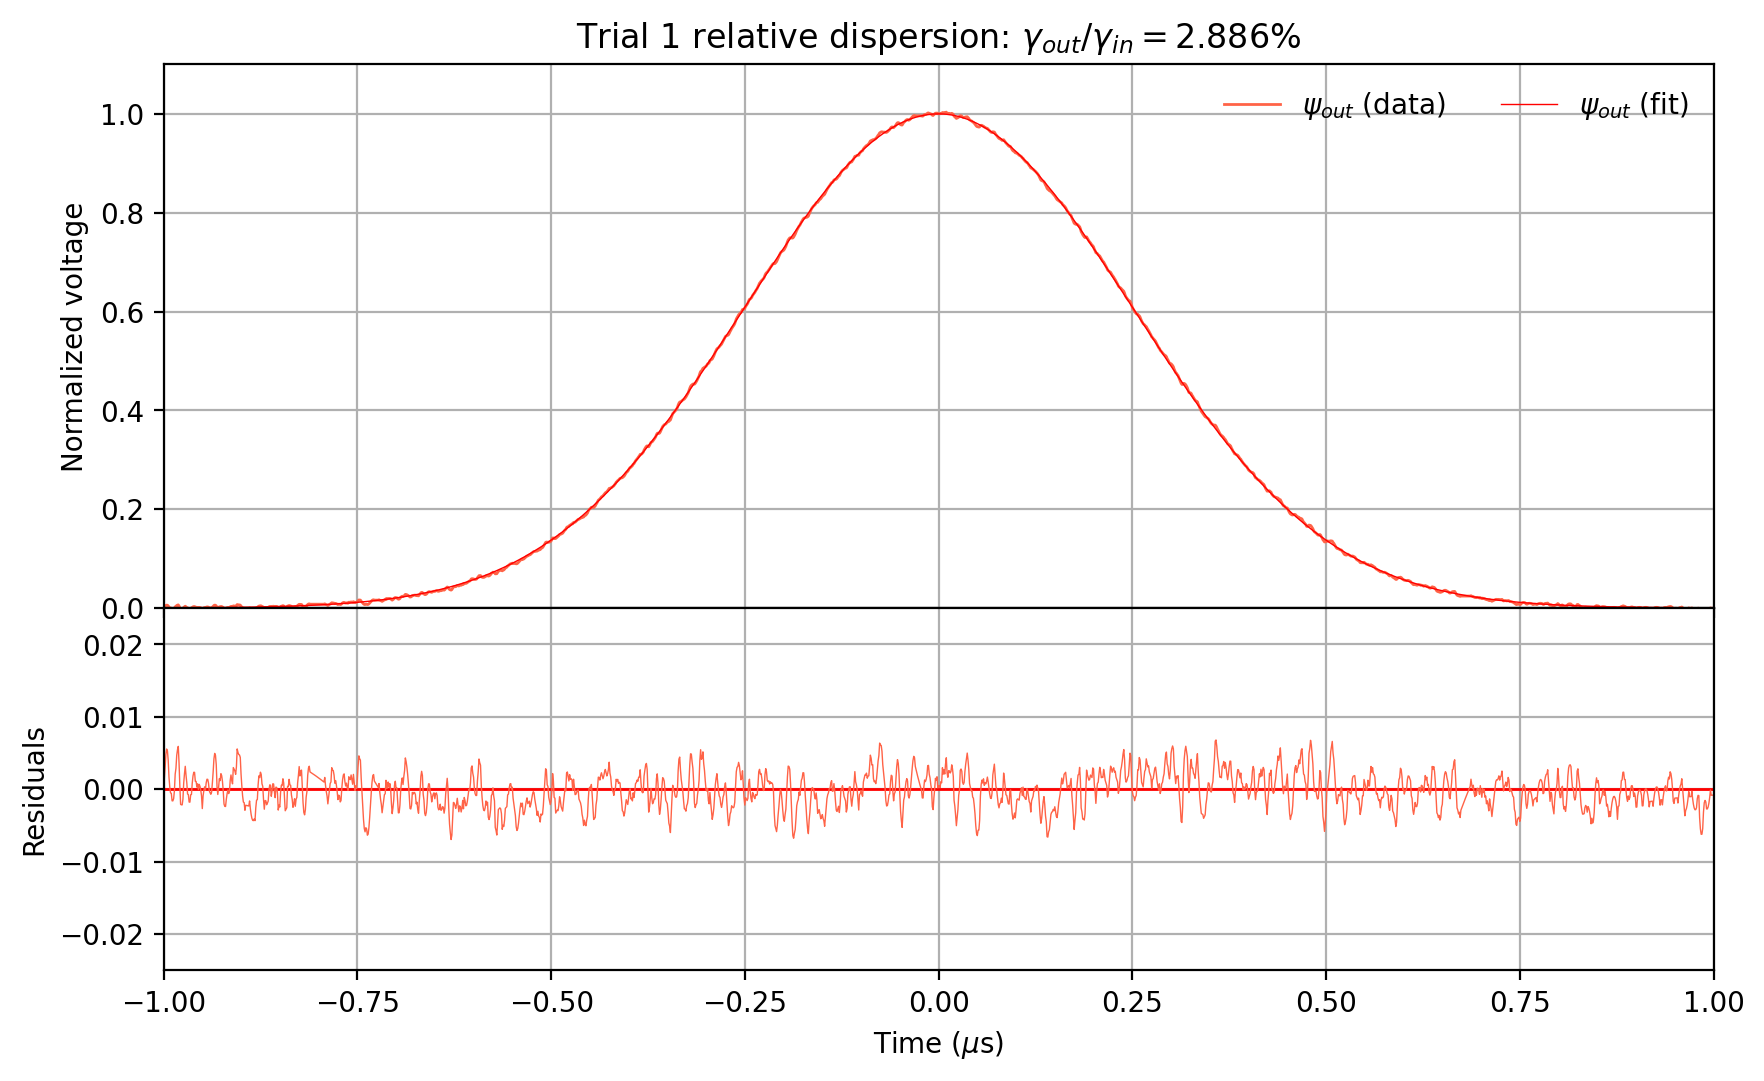

In [523]:
fig, [ax1, ax2] = plt.subplots(2,1,sharex=True,figsize=(10,6),gridspec_kw={'height_ratios': [3,2]})

plt.sca(ax1)
plt.title("Trial 1 relative dispersion: $\gamma_{out}/\gamma_{in} = $" + f"{100*(g2/g1-1):.3f}%")
# plt.plot(ret, re1, c="indigo", label="$\psi_{in}$ (data)", lw=1)
plt.plot(ret, re2, c="tomato", label="$\psi_{out}$ (data)", lw=1)
# plt.plot(t, curve(t, 1, g1), lw=0.5, c="blue", label="$\psi_{in}$ (fit)")
plt.plot(t, curve(t, 1, g2), lw=0.5, c="red", label="$\psi_{out}$ (fit)")
plt.ylim(0,1.1)
plt.xlim(-1,1)
plt.ylabel("Normalized voltage")
plt.grid()
plt.legend(frameon=False,ncol=2)

plt.sca(ax2)
plt.axhline(0, c="red", lw=1)
plt.ylabel("Residuals")
# plt.plot(ret, re1 - curve(ret, 1, g1), lw=0.5, c="indigo")
plt.plot(ret, re2 - curve(ret, 1, g2), lw=0.5, c="tomato")
plt.grid()
plt.ylim(-0.025,0.025)

plt.xlabel("Time ($\mu$s)")

plt.subplots_adjust(hspace=0)
plt.show()

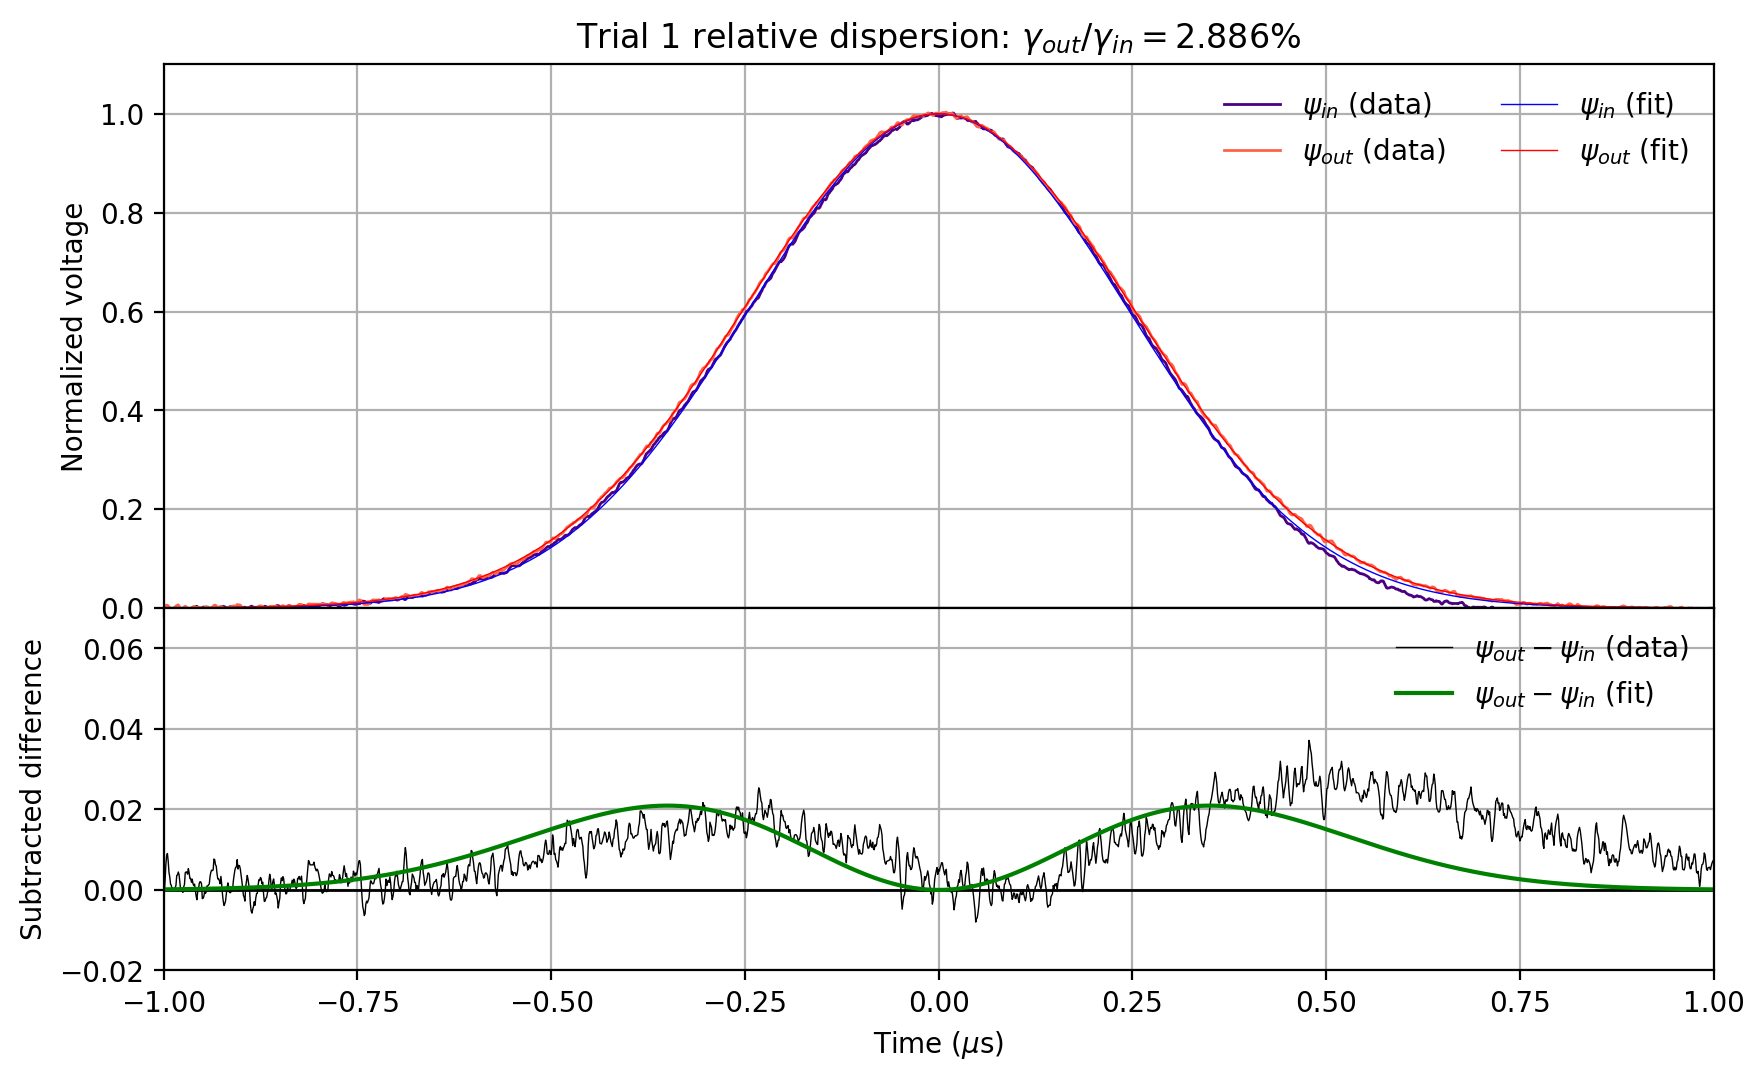

In [526]:
fig, [ax1, ax2] = plt.subplots(2,1,sharex=True,figsize=(10,6),gridspec_kw={'height_ratios': [3,2]})

plt.sca(ax1)
plt.title("Trial 1 relative dispersion: $\gamma_{out}/\gamma_{in} = $" + f"{100*(g2/g1-1):.3f}%")
plt.plot(ret, re1, c="indigo", label="$\psi_{in}$ (data)", lw=1)
plt.plot(ret, re2, c="tomato", label="$\psi_{out}$ (data)", lw=1)
plt.plot(t, curve(t, 1, g1), lw=0.5, c="blue", label="$\psi_{in}$ (fit)")
plt.plot(t, curve(t, 1, g2), lw=0.5, c="red", label="$\psi_{out}$ (fit)")
plt.ylim(0,1.1)
plt.xlim(-1,1)
plt.ylabel("Normalized voltage")
plt.grid()
plt.legend(frameon=False,ncol=2)

plt.sca(ax2)
plt.axhline(0, c="black", lw=1)
plt.ylabel("Subtracted difference")
plt.plot(ret, re2 - re1, lw=0.5, c="black", label="$\psi_{out} - \psi_{in}$ (data)")
plt.plot(ret, curve(ret, 1, g2) - curve(ret, 1, g1), c="green", label="$\psi_{out} - \psi_{in}$ (fit)")
plt.grid()
plt.ylim(-0.02,0.07)
plt.legend(frameon=False)

plt.xlabel("Time ($\mu$s)")

plt.subplots_adjust(hspace=0)
plt.show()


## Dispersion analysis

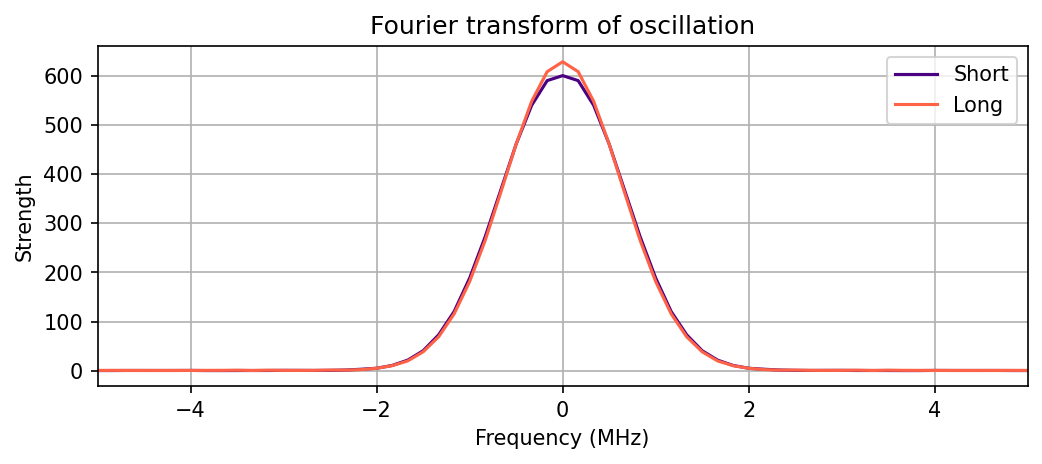

In [409]:
from scipy.fft import fft, fftfreq, fftshift

for (n, ch) in enumerate([ch1/A1, ch2/A2]):
    spectrum = np.abs(fftshift(fft(ch)))
    # spectrum /= np.max(spectrum)
    sampling_rate = 1 / dt
    freq = fftshift(fftfreq(t.size, dt))
    bin_width = np.average(np.diff(freq))
    plt.plot(freq, spectrum, label=("Short" if n==0 else "Long"), c=("indigo" if n==0 else "tomato"))

plt.title("Fourier transform of oscillation")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Strength")
plt.xlim(-5, 5)
# plt.ylim(0, 1.1)
plt.grid()
plt.legend()
plt.show()

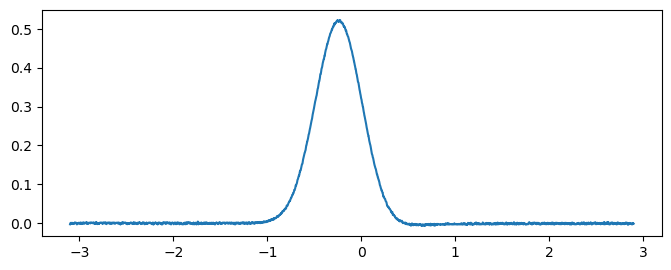

In [119]:
plt.plot(t, ch1)